In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas_profiling

In [2]:
train_df = pd.read_csv('Dataset/train.csv')
soln_df = pd.read_csv('Dataset/test.csv')

In [3]:
train_df.drop(['pet_id'], axis = 1, inplace = True)
main_test = soln_df.drop(['pet_id'], axis = 1)

In [4]:
def pre_process(df):
    df.condition.fillna(3, inplace=True)
    df['time_to_shelter'] = (pd.to_datetime(df.listing_date) - pd.to_datetime(df.issue_date)).dt.days
    df.drop(['issue_date','listing_date'], axis = 1, inplace=True)
    
    top_colors = [
                     'Black',
                     'White',
                     'Brown',
                     'Brown Tabby',
                     'Tan',
                     'Blue',
                     'Orange Tabby',
                     'Red',
                     'Brown Brindle',
                     'Tricolor',
                     'Blue Tabby',
                     'Tortie',
                     'Calico',
                     'Gray',
                     'Chocolate',
                     'Torbie',
                     'Cream Tabby',
                     'Sable',
                     'Cream',
                     'Fawn',
                     'Yellow',
                     'Buff',
                     'Lynx Point',
                     'Blue Merle'
                ]
    
    def reduce_color(color):
        if color in top_colors:
            return color
        return 'Other'
    
    df['color_mod'] = df.color_type.apply(reduce_color)
    df.drop(['color_type'], axis = 1, inplace=True)
    df.drop(['length(m)','height(cm)'], axis = 1, inplace= True)
    
    return df

In [5]:
train_df = pre_process(train_df)
main_test = pre_process(main_test)

In [6]:
train_y1 = train_df.loc[:,['breed_category']]
train_y2 = train_df.loc[:,['pet_category']]

In [7]:
train_X = train_df.drop(['breed_category','pet_category'], axis=1)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [9]:
ct = ColumnTransformer([("color", OneHotEncoder(sparse=False, drop='first'), [4])], remainder = 'passthrough')
ct.fit(train_X)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('color',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 [4])],
                  verbose=False)

In [10]:
train_X = ct.transform(train_X)
main_test = ct.transform(main_test)

In [11]:
print(train_X.shape)
print(main_test.shape)

(18834, 28)
(8072, 28)


In [12]:
from sklearn.model_selection import train_test_split

X_train_breed, X_test_breed, y_train_breed, y_test_breed = train_test_split(train_X, train_y1, test_size = 0.2)
X_train_pet, X_test_pet, y_train_pet, y_test_pet = train_test_split(train_X, train_y2, test_size = 0.2)

In [13]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler()

X_train_breed, y_train_breed = os.fit_resample(X_train_breed, y_train_breed)
X_train_pet, y_train_pet = os.fit_resample(X_train_pet, y_train_pet)

Using TensorFlow backend.


**Trial Viz**

In [67]:
y_train_breed.breed_category.astype('str').unique()

array(['1.0', '0.0', '2.0'], dtype=object)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

[[769.9558088272664 -7.518355361432698 '1.0']
 [3124.953729647156 -4.628453017391715 '1.0']
 [-610.0519849923577 -2.5479175737801203 '1.0']
 ...
 [28.936510820777276 7.0175287229494465 '2.0']
 [-517.0630071173682 6.347429263183235 '2.0']
 [-701.0597837124739 5.663933970944747 '2.0']]


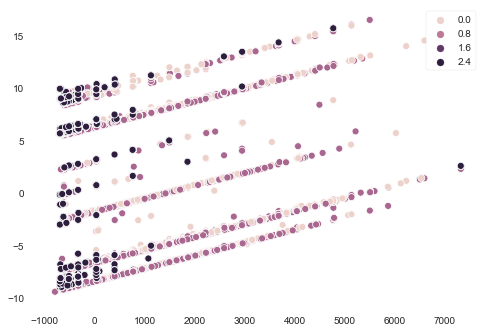

In [68]:
x = pca.fit_transform(X_train_breed)
breed_x = np.append(x, y_train_breed.breed_category.astype('str').values.reshape(-1,1), axis=1)
print(breed_x)
sns.scatterplot(x=breed_x[:,0], y=x[:,1], hue=breed_x[:,2])

[[  95.71311849   -6.34463347    2.        ]
 [-636.29339872    6.60724289    1.        ]
 [-452.28974258   -8.0767065     1.        ]
 ...
 [-273.29709802    7.4262649     4.        ]
 [-272.29709833    7.4266698     4.        ]
 [-272.29711345    7.43849509    4.        ]]


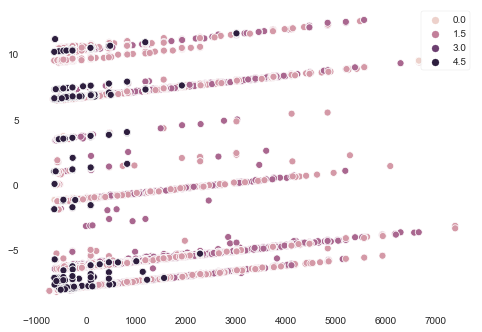

In [66]:
x = pca.fit_transform(X_train_pet)
pet_x = np.append(x, y_train_pet.pet_category.values.reshape(-1,1), axis=1)
print(pet_x)
sns.scatterplot(x=pet_x[:,0], y=x[:,1], hue=pet_x[:,2])

**DTREE**

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
breed_model = DecisionTreeClassifier().fit(X_train_breed, y_train_breed) 
breed_test_preds = breed_model.predict(X_test_breed) 
  
# creating a confusion matrix 
confusion_matrix(y_test_breed, breed_test_preds) 

array([[1659,  181,    0],
       [ 204, 1453,    0],
       [   0,    0,  270]])

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
pet_model = DecisionTreeClassifier().fit(X_train_pet, y_train_pet) 
pet_test_preds = pet_model.predict(X_test_pet) 
  
# creating a confusion matrix 
confusion_matrix(y_test_pet, pet_test_preds) 

array([[   3,    2,    4,    6],
       [   3, 1202,  224,   13],
       [   8,  268, 1838,   30],
       [   5,    6,   24,  131]])

In [37]:
breed_preds = breed_model.predict(main_test)

In [38]:
pet_preds = pet_model.predict(main_test)

In [44]:
submission = pd.DataFrame()

In [45]:
submission['pet_id'] = soln_df.pet_id

In [47]:
submission['breed_category'] = breed_preds

In [48]:
submission['pet_category'] = pet_preds

In [54]:
submission.breed_category = submission.breed_category.astype('int64')

In [55]:
submission

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,2
4,ANSL_72871,0,2
...,...,...,...
8067,ANSL_66809,1,2
8068,ANSL_59041,1,2
8069,ANSL_60034,1,2
8070,ANSL_58066,2,4


In [58]:
submission.to_csv('submission_1.csv',index=False)